<a href="https://colab.research.google.com/github/pdkary/VincentGANVogh/blob/main/VincentGANVogh.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vincent GAN Vogh
a simple GAN for creating works on art, totally ripping off Van Gogh's style, without any of the artistic expertise

## Imports


In [ ]:
%tensorflow_version 2.x
!pip install jupyterplot

import tensorflow as tf
from keras.layers import Conv2D, UpSampling2D, Input, Conv2DTranspose
from keras.layers import InputLayer, Dense, Reshape, Flatten, BatchNormalization, Dropout
from keras.layers import AveragePooling2D, Activation, InputSpec, Layer, MaxPooling2D
from keras.layers import GaussianNoise,Cropping2D, Lambda, Add
from keras.layers.advanced_activations import LeakyReLU
from keras.activations import tanh
from keras.models import Sequential, Model
from keras.optimizers import Adam
from keras.regularizers import l2
from keras import backend as K
from keras import initializers, regularizers, constraints
import matplotlib.pyplot as plt
import glob
from PIL import Image
import numpy as np
import os
import time
import tensorflow_hub as hub

from functools import partial
from jupyterplot import ProgressPlot
 
from google.colab import drive

## Configurations


In [ ]:
#INPUT SETTINGS
IMG_ROWS = 256
IMG_COLS = 256
CHANNELS = 3
FLAT_SIZE = IMG_ROWS*IMG_COLS*CHANNELS
 
#PREVIEW SETTINGS
PREVIEW_ROWS = 3
PREVIEW_COLS = 4
GENERATE_SQUARE = 256
PREVIEW_MARGIN = 16

#PLOT SETTINGS
MOVING_AVERAGE_SIZE = 50

#BATCH_SETTINGS 
BATCH_SIZE = 4
BUFFER_SIZE = 60000
LATENT_SIZE = 10
STYLE_SEED_SIZE = 100
KERNEL_SIZE = 3

#CONSTANTS
DROPOUT_RATE = 0.6
RELU_ALPHA = 0.1
REGULARIZATION_PENALTY = 0
GAUSS_FACTOR = 0.5
BATCH_NORM_MOMENTUM = 0.8

#TRAINING
LEARNING_RATE = 3e-4
MOMENTUM = 0.5

#SAVING
IMAGE_TYPE = ".png"
DATA_PATH = '/content/drive/MyDrive/Colab/BobRoss'
IMAGE_OUTPUT_PATH = DATA_PATH + '/images'
MODEL_OUTPUT_PATH = DATA_PATH + '/models'
MODEL_NAME = '/GANVogh_bob_generator_model_'
 
##compositions
IMG_SHAPE = (IMG_ROWS, IMG_COLS, CHANNELS)
LATENT_SHAPE = (LATENT_SIZE,) #1D array of size 100 (latent vector / noise)
STYLE_SHAPE = (STYLE_SEED_SIZE,)
BATCH_SHAPE = [BATCH_SIZE,IMG_ROWS,IMG_COLS,CHANNELS]
BATCH_NOISE = (BATCH_SIZE,STYLE_SEED_SIZE)

## Helper Functions

In [ ]:
def loadData(folder):
  glob_glob = folder + "/*" + IMAGE_TYPE
  images = glob.glob(glob_glob)
  print("LOADING FROM %s"%(glob_glob))
  print("LOADING %d IMAGES"%len(images))
  x = []
  for i in images:
    img = Image.open(i)
    img = img.convert('RGBA') if CHANNELS == 4 else img.convert('RGB')
    img = img.resize(size=(IMG_ROWS,IMG_COLS),resample=Image.ANTIALIAS)
    img = np.array(img).astype('float32')
    img = img/255
    x.append(img)
    x.append(np.fliplr(img))
    
  print("LOADED %d IMAGES"%len(x))
  i = np.random.randint(0,len(x)-1,size=1)[0]
  print("SHOWING IMAGE: ",i)
  displayed_img = x[i]
  img_min = displayed_img.min()
  img_max = displayed_img.max()
  displayed_img = (displayed_img-img_min)/(img_max - img_min)
  plt.imshow(displayed_img)
  return x

## Model Definition

### Minibatch Discrimination Layer
found on github, in need of citation

In [ ]:
class MinibatchDiscrimination(Layer):
    def __init__(self, nb_kernels, kernel_dim, init='glorot_uniform', weights=None,
                 W_regularizer=None, activity_regularizer=None,
                 W_constraint=None, input_dim=None, **kwargs):
        self.init = initializers.get(init)
        self.nb_kernels = nb_kernels
        self.kernel_dim = kernel_dim
        self.input_dim = input_dim

        self.W_regularizer = regularizers.get(W_regularizer)
        self.activity_regularizer = regularizers.get(activity_regularizer)

        self.W_constraint = constraints.get(W_constraint)

        self.initial_weights = weights
        self.input_spec = [InputSpec(ndim=2)]

        if self.input_dim:
            kwargs['input_shape'] = (self.input_dim,)
        super(MinibatchDiscrimination, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 2

        input_dim = input_shape[1]
        self.input_spec = [InputSpec(dtype=K.floatx(),shape=(None, input_dim))]

        self.W = self.add_weight(
            shape=(self.nb_kernels, input_dim, self.kernel_dim),
            initializer=self.init,
            name='kernel',
            regularizer=self.W_regularizer,
            trainable=True,
            constraint=self.W_constraint)

        super(MinibatchDiscrimination, self).build(input_shape)

    def call(self, x, mask=None):
        activation = K.reshape(K.dot(x, self.W), (-1, self.nb_kernels, self.kernel_dim))
        diffs = K.expand_dims(activation, 3) - K.expand_dims(K.permute_dimensions(activation, [1, 2, 0]), 0)
        abs_diffs = K.sum(K.abs(diffs), axis=2)
        minibatch_features = K.sum(K.exp(-abs_diffs), axis=2)
        return K.concatenate([x, minibatch_features], 1)

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], input_shape[1]+self.nb_kernels

    def get_config(self):
        config = super(MinibatchDiscrimination, self).get_config().copy()
        config.update({'nb_kernels': self.nb_kernels,
                  'kernel_dim': self.kernel_dim,
                  'init': self.init.get_config(),
                  'W_regularizer': self.W_regularizer.get_config() if self.W_regularizer else None,
                  'activity_regularizer': self.activity_regularizer.get_config() if self.activity_regularizer else None,
                  'W_constraint': self.W_constraint.get_config() if self.W_constraint else None,
                  'input_dim': self.input_dim})
        return config

### Model


#### Style Model

In [ ]:
#Style Z and latent noise
def noise(batch_size=BATCH_SIZE,seed_size=STYLE_SEED_SIZE,stdev=1):
  batch_noise = (batch_size,seed_size)
  return tf.random.normal(shape = batch_noise,mean=0.0,stddev=stdev)

#Noise Sample
def noiseImage(batch_size=BATCH_SIZE):
  batch_shape = (batch_size,IMG_ROWS,IMG_COLS,CHANNELS)
  return tf.random.normal(shape = batch_shape,mean=0.0,stddev=GAUSS_FACTOR)

In [ ]:
def style_model_block(input_tensor,size):
  out = Dense(size, kernel_initializer = 'he_normal')(input_tensor)
  out = LeakyReLU(RELU_ALPHA)(out)
  return out

def build_style_model(input_tensor,size,layers):
  style_model = style_model_block(input_tensor,size)
  for i in range(layers-1):
    style_model = style_model_block(style_model,size)
  return style_model

#### Generator

In [ ]:
def AdaIN(input_arr):
    input_tensor, gamma, beta = input_arr
    mean = K.mean(input_tensor, axis = [1, 2], keepdims = True)
    std = K.std(input_tensor, axis = [1, 2], keepdims = True) + 1e-7
    y = (input_tensor - mean) / std
    
    pool_shape = [-1, 1, 1, y.shape[-1]]
    scale = K.reshape(gamma, pool_shape)
    bias = K.reshape(beta, pool_shape)
    return y * scale + bias

def generator_block(input_tensor,style_model,noise_dict,filters,convolutions,upsampling=True,style=True,noise=True):
  out = input_tensor
  out = UpSampling2D(interpolation='bilinear')(out) if upsampling else out
  noise_model = noise_dict[out.shape[1]]
  for i in range(convolutions):
    if noise:
      noise_model = Conv2D(filters,1,padding='same',kernel_initializer='he_normal')(noise_model)
    if style:
      gamma = Dense(filters,bias_initializer='ones')(style_model)
      beta = Dense(filters,bias_initializer='zeros')(style_model)
    
    out = Conv2D(filters,kernel_size=KERNEL_SIZE,padding='same', kernel_initializer = 'he_normal')(out)
    out = Lambda(AdaIN)([out,gamma,beta]) if style else BatchNormalization(momentum=BATCH_NORM_MOMENTUM)(out)
    out = Add()([out,noise_model]) if noise else out
    out = LeakyReLU(RELU_ALPHA)(out)
  return out

def build_generator(latent_input_tensor,style_model,noise_dict,filename=None):
  if filename is not None:
    return tf.keras.models.load_model(filename)
  else:
    gen_model = Dense(4*4*1024, kernel_initializer = 'he_normal')(latent_input_tensor)
    gen_model = Reshape((4,4,1024))(gen_model)
    gen_model = generator_block(gen_model,style_model,noise_dict,1024,3)
    gen_model = generator_block(gen_model,style_model,noise_dict,512,3)
    gen_model = generator_block(gen_model,style_model,noise_dict,256,2)
    gen_model = generator_block(gen_model,style_model,noise_dict,128,2)
    gen_model = generator_block(gen_model,style_model,noise_dict,64,1)
    gen_model = generator_block(gen_model,style_model,noise_dict,32,1)
    return Conv2D(filters=CHANNELS, kernel_size=1, padding='same',activation='sigmoid')(gen_model)


#### Discriminator

In [ ]:
def disc_dense_block(input_tensor,size,dropout=True,minibatch=False):
  out_db = Dense(size, kernel_initializer = 'he_normal')(input_tensor)
  out_db = LeakyReLU(RELU_ALPHA)(out_db)
  out_db = Dropout(DROPOUT_RATE)(out_db) if dropout else out_db
  out_db = MinibatchDiscrimination(size//4, IMG_ROWS)(out_db) if minibatch else out_db
  return out_db
  
def disc_conv_block(input_tensor, filters, convolutions):
  out_cb = input_tensor
  for i in range(convolutions):
    out_cb = Conv2D(filters,kernel_size=KERNEL_SIZE,padding="same",kernel_regularizer=l2(REGULARIZATION_PENALTY))(out_cb)
    out_cb = LeakyReLU(RELU_ALPHA)(out_cb)
 
  out_cb = MaxPooling2D()(out_cb)
  return out_cb
 
def build_discriminator(disc_model_input):
    disc_model = disc_conv_block(disc_model_input,16,1)
    disc_model = disc_conv_block(disc_model,32,2)
    disc_model = disc_conv_block(disc_model,64,2)
    disc_model = disc_conv_block(disc_model,128,2)
    disc_model = disc_conv_block(disc_model,256,2)
    disc_model = disc_conv_block(disc_model,512,3)
    disc_model = Flatten()(disc_model)
    disc_model = disc_dense_block(disc_model,2048)
    disc_model = disc_dense_block(disc_model,1000,minibatch=True)
    
    disc_model = Dense(1,activation="sigmoid")(disc_model)
    return disc_model

## DCGAN Class and GANTrainer

In [ ]:
real_image_input = Input(shape=IMG_SHAPE, name="image_input")
latent_model_input = Input(shape=LATENT_SIZE, name="latent_space_input")
noise_model_input = Input(shape=IMG_SHAPE,name="noise_image_input")
style_model_input = Input(shape=STYLE_SHAPE,name="style_input")

class DCGAN():
  def __init__(self,style=True,noise=True):
    self.S = None
    self.N = None
    self.is_stylish=style
    self.is_noisy=noise
    self.ad_optimizer = Adam(LEARNING_RATE, beta_1 = 0, beta_2 = 0.99, decay = 0.00001)
    self.dis_optimizer = Adam(LEARNING_RATE, beta_1 = 0, beta_2 = 0.99, decay = 0.00001)

    if noise and style:
      self.noisy_input = [style_model_input,noise_model_input,latent_model_input]
      self.init_noise_model()
      self.init_style_model()
    elif noise:
      self.noisy_input = [noise_model_input,latent_model_input]
      self.init_noise_model()
    elif style:
      self.noisy_input = [style_model_input,latent_model_input]
      self.init_style_model()
    else:
      self.noisy_input = [latent_model_input]

    self.full_input = [real_image_input,*self.noisy_input]
    self.init_generator()
    self.init_discriminator()

  def init_generator(self):
    G = build_generator(latent_model_input,self.S,self.noise_dict)
    self.G = Model(inputs=self.noisy_input,outputs=G, name="generator_base")
    self.G.compile(optimizer=self.ad_optimizer,loss="binary_crossentropy",metrics=["accuracy"])
    
  def init_discriminator(self):
    D = build_discriminator(real_image_input)
    self.D = Model(inputs=real_image_input,outputs=D,name="discriminator_base")
    self.D.compile(optimizer=self.dis_optimizer,loss="binary_crossentropy",metrics=["accuracy"])
  
  def init_style_model(self):
    self.S = build_style_model(style_model_input,64,4)
  
  def init_noise_model(self):
    self.N = Activation('linear')(noise_model_input)
    noise_layers = [self.N]
    noise_sizes = [self.N.shape[1]]
    curr_size = self.N.shape[1]
    while curr_size > 4:
      curr_size = curr_size//2
      noise_layers.append(Cropping2D(curr_size//2)(noise_layers[-1]))
      noise_sizes.append(curr_size)
    
    self.noise_dict = dict(zip(noise_sizes,noise_layers))

  def set_trainable(self,gen_state,disc_state):
    self.G.trainable = gen_state
    self.D.trainable = disc_state
    for layer in self.G.layers:
      layer.trainable = gen_state
    for layer in self.D.layers:
      layer.trainable = disc_state

  def AdModel(self):
    self.set_trainable(True,False)
    generated_output = self.G(self.noisy_input)
    discriminated_output = self.D(generated_output,training=False)
    self.ad_model = Model(inputs=self.noisy_input,outputs=discriminated_output,name="adversarial_model")
    self.ad_model.compile(optimizer=self.ad_optimizer,loss='binary_crossentropy',metrics=['accuracy'])
    self.ad_model.summary()
    return self.ad_model
  
  def DisModel(self):
    self.set_trainable(False,True)
    d_real = self.D(real_image_input)
    generated_imgs = self.G(self.noisy_input)
    d_fake = self.D(generated_imgs)
    d_partial = self.D(real_image_input)

    self.dis_model = Model(inputs=self.full_input,outputs=[d_real,d_fake,d_partial],name="discriminator_model")
    self.dis_model.compile(optimizer=self.dis_optimizer,loss=['binary_crossentropy','binary_crossentropy','binary_crossentropy'],metrics=['accuracy'])
    self.dis_model.summary()
    return self.dis_model
  
  def save_images(self,cnt):
    n = PREVIEW_COLS*PREVIEW_ROWS
    latent_noise = noise(n,LATENT_SIZE)
    preview_width = PREVIEW_MARGIN + (PREVIEW_COLS * (GENERATE_SQUARE+PREVIEW_MARGIN))
    preview_height = PREVIEW_MARGIN + (PREVIEW_ROWS * (GENERATE_SQUARE+PREVIEW_MARGIN))
    
    if self.is_noisy and self.is_stylish:
      seed = [noise(n),noiseImage(n),latent_noise]
    elif self.is_stylish:
      seed = [noise(n),latent_noise]
    elif self.is_noisy:
      seed = [noiseImage(n),latent_noise]
    else:
      seed = [latent_noise]
    
    image_array = np.full((preview_height, preview_width,CHANNELS), 255, dtype=np.uint8)
    generated_images = np.array(self.G.predict(seed))
    
    image_count = 0
    for row in range(PREVIEW_ROWS):
        for col in range(PREVIEW_COLS):
          r = row * (GENERATE_SQUARE+PREVIEW_MARGIN) + PREVIEW_MARGIN
          c = col * (GENERATE_SQUARE+PREVIEW_MARGIN) + PREVIEW_MARGIN
          img = generated_images[image_count]
          img_min = img.min()
          img_max = img.max()
          image_array[r:r+GENERATE_SQUARE,c:c+GENERATE_SQUARE] = 255*(img - img_min)/(img_max-img_min)
          image_count += 1
  
    filename = os.path.join(IMAGE_OUTPUT_PATH,f"train-{cnt}" + IMAGE_TYPE)
    im = Image.fromarray(image_array)
    im.save(filename)

In [ ]:
class GanTrainer(object):
  def __init__(self,style=True,noise=True):
    self.ones = np.ones(shape=(BATCH_SIZE,))
    self.GAN = DCGAN(style,noise)
    self.AdModel = self.GAN.AdModel()
    self.DisModel = self.GAN.DisModel()
  
  def train_generator(self, noise_data):
    self.GAN.set_trainable(True,False)
    g_loss,g_acc = self.AdModel.train_on_batch(noise_data,self.ones)
    return g_loss,g_acc
  
  def train_discriminator(self,training_data):
    self.GAN.set_trainable(False,True)
    noisy_ones = tf.random.normal(shape = (BATCH_SIZE,),mean=1.0,stddev=0.01)
    noisy_zeros = tf.random.normal(shape = (BATCH_SIZE,),mean=0.0,stddev=0.01)
    d_losses = self.DisModel.train_on_batch(training_data,[self.ones,noisy_zeros,noisy_ones])
    label = self.DisModel.metrics_names.index('discriminator_base_accuracy')
    return d_losses[0],d_losses[label]
    
  def train_step(self,training_imgs,noise_input):
    full_input = [training_imgs, *noise_input]
    g_loss,g_acc = self.train_generator(noise_input)
    d_loss,d_acc = self.train_discriminator(full_input)
    return d_loss,d_acc,g_loss,g_acc
  
  def train(self,progress_plot,dataset,epochs,batches_per_epoch,printerval):
    d_loss_ma_buffer, g_loss_ma_buffer = [], []
    d_acc_ma_buffer, g_acc_ma_buffer = [], []
    time_ma_buffer = []
    latent_noise = noise(seed_size=LATENT_SIZE)

    for epoch in range(epochs):
      epoch_start = time.time()
      batch_d_loss, batch_g_loss = [], []
      batch_d_acc, batch_g_acc = [], []

      batches_in_epoch = np.random.randint(0,len(dataset)-1,size=batches_per_epoch)
  
      for i,image_batch in enumerate(dataset):
        if i in batches_in_epoch and len(image_batch) == BATCH_SIZE:
          training_imgs = image_batch.numpy()
          if self.GAN.is_stylish and self.GAN.is_noisy:
            noise_input = [noise(),noiseImage()]
          elif self.GAN.is_stylish:
            noise_input = [noise()]
          elif self.GAN.is_noisy:
            noise_input = [noiseImage()]

          noise_input.append(latent_noise)
          bd_loss,bd_acc,bg_loss,bg_acc = self.train_step(training_imgs,noise_input)
          batch_d_loss.append(bd_loss)
          batch_g_loss.append(bg_loss)
          batch_d_acc.append(bd_acc)
          batch_g_acc.append(bg_acc)
      
      d_loss, g_loss = np.mean(batch_d_loss),np.mean(batch_g_loss)
      d_acc, g_acc = np.mean(batch_d_acc), np.mean(batch_g_acc)

      if epoch % printerval == 0:
        self.GAN.save_images(epoch)

      epoch_elapsed = time.time()-epoch_start

      if epoch >= 10:
        d_loss_ma_buffer.append(d_loss)
        g_loss_ma_buffer.append(g_loss)
        d_acc_ma_buffer.append(d_acc)
        g_acc_ma_buffer.append(g_acc)
        time_ma_buffer.append(epoch_elapsed)

        d_loss_ma_buffer = d_loss_ma_buffer[1:] if len(d_loss_ma_buffer) >= MOVING_AVERAGE_SIZE else d_loss_ma_buffer
        g_loss_ma_buffer = g_loss_ma_buffer[1:] if len(g_loss_ma_buffer) >= MOVING_AVERAGE_SIZE else g_loss_ma_buffer
        d_acc_ma_buffer = d_acc_ma_buffer[1:] if len(d_acc_ma_buffer) >= MOVING_AVERAGE_SIZE else d_acc_ma_buffer
        g_acc_ma_buffer = g_acc_ma_buffer[1:] if len(g_acc_ma_buffer) >= MOVING_AVERAGE_SIZE else g_acc_ma_buffer
        time_ma_buffer = time_ma_buffer[1:] if len(time_ma_buffer) >= MOVING_AVERAGE_SIZE else time_ma_buffer

        d_loss_ma,g_loss_ma = np.mean(d_loss_ma_buffer),np.mean(g_loss_ma_buffer)
        d_acc_ma,g_acc_ma = np.mean(d_acc_ma_buffer), np.mean(g_acc_ma_buffer)
        time_ma = np.mean(time_ma_buffer)

        # progress_plot.update([[d_loss,d_loss_ma],[g_loss,g_loss_ma],[epoch_elapsed,time_ma]])
        progress_plot.update([[d_loss,d_loss_ma],[d_acc,d_acc_ma],[g_loss,g_loss_ma],[g_acc,g_acc_ma],[epoch_elapsed,time_ma]])

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
LOADING FROM /content/drive/MyDrive/Colab/BobRoss/*.png
LOADING 250 IMAGES
LOADED 500 IMAGES
SHOWING IMAGE:  77


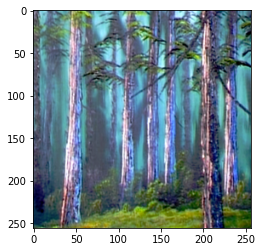

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
images = loadData(DATA_PATH)

In [ ]:
print("Preparing Dataset".upper())
train_dataset = tf.data.Dataset.from_tensor_slices(images).batch(BATCH_SIZE)
print("DATASET LOADED")

PREPARING DATASET
DATASET LOADED


In [ ]:
ERAS = 100
EPOCHS = 1000
BATCHES_PER_EPOCH = 10
PRINT_EVERY = 10
 
gan_trainer = GanTrainer(style=True,noise=True)
pp = ProgressPlot(plot_names =['D Loss','D acc','G Loss','G acc', 'Epoch Duration'],line_names=["value", "MA"])
# pp = ProgressPlot(plot_names =['D Loss','G Loss', 'Epoch Duration'],line_names=["value", "MA"])
for i in range(ERAS):
    gan_trainer.train(pp,train_dataset, EPOCHS, BATCHES_PER_EPOCH,PRINT_EVERY)
    filename = MODEL_NAME + "%dk"%(i+1)
    gan_trainer.GAN.D.save(MODEL_OUTPUT_PATH + filename)

Model: "adversarial_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
style_input (InputLayer)        [(None, 100)]        0                                            
__________________________________________________________________________________________________
noise_image_input (InputLayer)  [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
latent_space_input (InputLayer) [(None, 10)]         0                                            
__________________________________________________________________________________________________
generator_base (Functional)     (None, 256, 256, 3)  43683715    style_input[0][0]                
                                                                 noise_image_input

<IPython.core.display.Javascript object>

INFO:tensorflow:Assets written to: /content/drive/MyDrive/Colab/BobRoss/models/GANVogh_bob_generator_model_1k/assets


<IPython.core.display.Javascript object>